<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/GATr_Deep_Learning_Project/blob/main/GATr_deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
!git clone https://github.com/FedericoRaschiatore0123/GATr_Deep_Learning_Project.git

Cloning into 'GATr_Deep_Learning_Project'...
remote: Enumerating objects: 4125, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 4125 (delta 2), reused 0 (delta 0), pack-reused 4119
Receiving objects: 100% (4125/4125), 1.68 GiB | 25.95 MiB/s, done.
Resolving deltas: 100% (73/73), done.
Updating files: 100% (4003/4003), done.


In [1]:
#librerie
!pip install h5py
!pip install trimesh
!pip install torch_geometric
!pip install pyquaternion
!pip install clifford

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch_geometric.data
from torch_geometric.data import Data
from torch.utils.data import random_split, ConcatDataset, Subset
from pyquaternion import Quaternion
import clifford as cf

import h5py
import os
import trimesh
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.8/693.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00


#Global Variables

In [ ]:
single_path ='/content/GATr_Deep_Learning_Project/single/'
bifurcating_path = '/content/GATr_Deep_Learning_Project/bifurcating/'

BATCH_SIZE = 1

# create a dictionary of global variables
global_variables = {

    'dim_GA': 16
}

#Get device

In [ ]:
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')

#Dataset and Dataloader

In [ ]:
print(len(os.listdir(single_path)))
print(len(os.listdir(bifurcating_path)))

2000
1999


In [ ]:
class Preprocesing():
  def __init__(self, path_single, path_bifurcating):

    self.single_data_path = path_single
    self.bifurcating_data_path = path_bifurcating

  def build_datasets(self):

    single_dataset = self.load_data(self.single_data_path,  bifurcating=False)
    bifurcating_dataset = self.load_data(self.bifurcating_data_path,  bifurcating=True)

    combined_dataset = self.shuffle_and_combine_datasets(single_dataset, bifurcating_dataset)

    return self.split_dataset(combined_dataset)


  def load_data(self, path, bifurcating=False):
    data = []
    for file in os.listdir(path):
      with h5py.File(path + file, 'r') as input_file:
        data.append([
              torch.from_numpy(input_file['wss'][()]),
              torch.from_numpy(input_file['pos'][()]),
              torch.from_numpy(input_file['pressure'][()]),
              torch.from_numpy(input_file['face'][()].T).long(),
              torch.from_numpy(input_file['inlet_idcs'][()])
          ])

    label = torch.ones(len(data)) if bifurcating else torch.zeros(len(data))

    return list(zip(data, label))


  def shuffle_and_combine_datasets(self, dataset1, dataset2):

      combined_dataset = ConcatDataset([dataset1, dataset2])
      indices = torch.randperm(len(combined_dataset))
      shuffled_dataset = Subset(combined_dataset, indices)

      return shuffled_dataset

  def split_dataset(self, dataset, train_ratio=0.7, validation_ratio=0.2, test_ratio=0.1):

      total_size = len(dataset)
      train_size = int(total_size * train_ratio)
      validation_size = int(total_size * validation_ratio)
      test_size = total_size - train_size - validation_size

      train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

      return train_dataset, validation_dataset, test_dataset


dataset = Preprocesing(single_path, bifurcating_path)
train_dataset, validation_dataset, test_dataset = dataset.build_datasets()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_loader)
print(validation_loader)
print(test_loader)

In [ ]:
print(next(iter(train_loader)))

[[tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]), tensor([[[-0.1137,  0.0690,  0.0012],
         [-0.1196,  0.0579,  0.0021],
         [-0.1191,  0.0578,  0.0021],
         ...,
         [-0.0537, -0.0154,  0.0034],
         [ 0.0657,  0.0021, -0.0031],
         [-0.0137, -0.0217,  0.0021]]]), tensor([[134385.6719, 134383.4375, 134382.7656,  ..., 134304.8594,
         134308.8438, 134306.8906]]), tensor([[[    1,     1,     1,  ..., 10792, 10741, 10725],
         [    0,     3,     4,  ..., 10752, 10653, 10784],
         [    2,     0,     3,  ..., 10653, 10752, 10781]]]), tensor([[    2,     1,     0,  9696,  9695,  9968,  9969,     3,  6745,  9278,
            13,    12,    11,  9692,  9691,  9970,  9971,    14,  9693,  9694,
            21,    23,    22,    24,  9688,  9689,  9972,    29,    26,  9973,
            28,    27,    34,    37,  9974,  9975,    36,    35,  7243,  724

#Show data

In [ ]:
single_list = os.listdir(single_path)

with h5py.File(single_path + single_list[random.randint(0, len(single_list))] , 'r') as file:

    vertices = np.array(file['pos'])
    faces = np.array(file['face'])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
mesh.show()

In [ ]:
bifurcating_list = os.listdir(bifurcating_path)

with h5py.File(bifurcating_path + bifurcating_list[random.randint(0, len(bifurcating_list))] , 'r') as file:
    vertices = np.array(file['pos'])
    faces = np.array(file['face'])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
mesh.show()

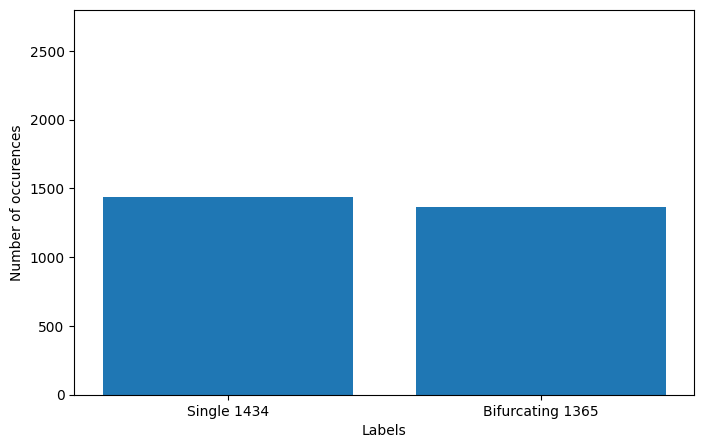

In [ ]:
def check_balancing(dataset):
  label = []
  for _ , element in enumerate(dataset):
    label.append(element[-1])

  categories = ['Single ' +  str(label.count(0)), 'Bifurcating ' +  str(label.count(1))]

  fig, ax = plt.subplots(figsize = (8,5))

  bars = ax.bar(
      categories,
      [label.count(0), label.count(1)],
      align = 'center'
    )

  ax.set_xlabel('Labels')
  ax.set_ylabel('Number of occurences')

  plt.ylim(ymax = len(label))
  plt.show()

check_balancing(train_dataset)

# Geometric Algebra

Geometric algebra G_{3,0,1} is characterized by 4 basic elements (e_{0}, e_{1}, e_{2}, e_{3}) that represent planes in the 3D space. These 4 basic elements can be combined through linear combination and geometric transformation to represent geometric objects of different dimensions (planes, lines, points), and transformations of different types (reflections, translations, rotations).

G_{3,0,1} indicates that the basis is composed by three elements (e_{1}, e_{2}, e_{3}) that satisfy e_{i}e_{i} = 1 and one (e_{0}) that satisfies e_{0}e_{0} = 0.

The basis components of the multivector associated to the G_{3,0,1} algebra are obtained by considering every possible multiplicative combination of the basis elements. Elements of different grade are thus obtained:

Grade 0 (1): scalars in the G.A. \\
Grade 1 (e_{0}, e_{i}): vectors in the G.A. \\
Grade 2 (e_{0i}, e_{ij}); bivectors in the G.A. \\
Grade 3 (e_{0ij}, e_{ijk}): trivectors in the G.A. \\
Grade 4 (e_{0123}): pseudoscalars in the G.A. \\

The multivector representation associated to the Geometric Algebra G_{3,0,1} will thus be composed of a total of 16 elements.

Scalars will be represented by grade 0 elements, planes by grade 1 elements, lines by grade 2 elements, points by grade 3 elements and pseudoscalar by grade 4 elements.

In [ ]:
def embed_pos_mv_16(pos):
    """
    Embeds the pos torch tensor as a 16-dimensional G_{3,0,1} multivector

    Args:
        pos (torch.Tensor): tensor of input points with shape (n_elements, 3)

    Returns:
        pos_mv torch.Tensor: tensor of multivectors of dimension 16 with shape (1, n_elements, 1, 16)
    """
    # Positions in Euclidean geometry can be embedded as points in G_{3,0,1} algebra

    # Get the number of points and the dimensionality
    n_elements = pos.shape[0]
    dim = pos.shape[1]

    # Create multivector tensor
    multivector = torch.zeros(n_elements, global_variables['dim_GA'])

    multivector[:, 14] = 1 # homogeneous component, e_{123}
    multivector[:, 11] = pos[:, 0] # x, e_{023}
    multivector[:, 12] = pos[:, 1] # y, e_{013}
    multivector[:, 13] = pos[:, 2] # z, e_{012}

    pos_mv = multivector.reshape(1,n_elements,1,global_variables['dim_GA'])

    return pos_mv

In [ ]:
def embed_face_mv_16(face):
    """
    Embeds the face torch tensor as a 16-dimensional G_{3,0,1} multivector

    Input:
        face torch.Tensor of size (n_elements, 3)
    Output:
        mv torch.Tensor of size (1, n_elements, 1, 16)
    """

    # An oriented surface in Euclidean geometry characterized by
    #   the normal vector n to the surface itself can be embedded as an oriented
    #   plane in G_{3,0,1} algebra


    # Get the number of points and the dimensionality of the space
    n_elements = face.shape[0]
    dim = face.shape[1]

    # Create multivector tensor
    multivector = torch.zeros(n_elements, global_variables['dim_GA'])

    multivector[:, 2] = face[:, 0] # e_{1}
    multivector[:, 3] = face[:, 1] # e_{2}
    multivector[:, 4] = face[:, 2] # e_{3}

    face_mv = multivector.reshape(1,n_elements,1,global_variables['dim_GA'])

    return face_mv

In [ ]:
def embed_wss_mv_16(wss):
    """
    Embeds the wss vectors as a 16 dimensional G_{3,0,1} multivector
    Input:
      wss torch.Tensor of size (n_elements, 3)
    Output:
      wss_mv torch.Tensor of size (1, n_elements, 1, 16)
    """

    # A 3D vector in the Euclidean space can be embedded as a translation in G_{3,0,1} algebra

    n_elements = wss.shape[0]
    dim = wss.shape[1]

    multivector = torch.zeros(n_elements, global_variables['dim_GA'])

    multivector[:, 0] = 1
    multivector[:, 5] = 0.5*wss[:, 0] # e_{01}
    multivector[:, 6] = 0.5*wss[:, 1] # e_{02}
    multivector[:, 7] = 0.5*wss[:, 2] # e_{03}

    wss_mv = multivector.reshape(1,n_elements,1,global_variables['dim_GA'])

    return wss_mv

In [ ]:
def embed_inlet_mv_16(inlet):
    """
    Embeds the inlet torch tensor as a 16 dimensional G_{3,0,1} multivector
    Input:
        inlet torch.Tensor of size (n_elements, 1)
    Output:
        inlet_mv torch.Tensor of size (1, n_elements, 1, 16)
    """
    # Inlet indexes can be embedded as scalars in G_{3,0,1} algebra

    n_elements = inlet.shape[0]

    multivector = torch.zeros(n_elements, global_variables['dim_GA'])
    multivector[:, 0] = inlet[:]

    inlet_mv = multivector.reshape(1, n_elements, 1, global_variables['dim_GA'])

    return inlet_mv

In [ ]:
def embed_pressure_mv_16(pressure):
  """
  Embeds the pressure torch tensor as a 16-dimensional G_{3,0,1} multivector
  Input:
    pressure torch.Tensor of size (n_elements, 1)
  Output:
    pressure_mv torch.Tensor of size (1, n_elements, 1, 16)
  """

  n_elements = pressure.shape[0]

  # Initialize the multivector
  multivector = torch.zeros(n_elements, global_variables['dim_GA'])

  multivector[:,0] = pressure[:]
  pressure_mv = multivector.reshape(1, n_elements, 1, global_variables['dim_GA'])

  return pressure_mv

In [ ]:
def embed_complete_mv_16(sample_path):
  # passa alla funzione il sample path,
  # fagli estrarre i tensori in torch,
  # fai l'embedding per ogni componente
  # e infine concatena tutti gli embedding

  # ritorna il multivector completo per il sample con path sample_path

  with h5py.File(sample_path, 'r') as f:
    # extract torch tensor for pos
    pos_data = f['pos'][:50]
    pos_torch = torch.tensor(pos_data[:])

    # extract torch tensor for face
    face_data = f['face'][:50]
    face_torch = torch.tensor(face_data[:])

    # extract torch tensor for wss
    wss_data = f['wss'][:50]
    wss_torch = torch.tensor(wss_data[:])

    # extract torch tensor for pressure
    pressure_data = f['pressure'][:50]
    pressure_torch = torch.tensor(pressure_data[:])

    # extract torch tensor for inlet_idcs
    inlet_data = f['inlet_idcs'][:50]
    inlet_torch = torch.tensor(inlet_data[:])

  # Get the multivector embeddings for each torch tensor
  pos_mv_16 = embed_pos_mv_16(pos_torch)
  face_mv_16 = embed_face_mv_16(face_torch)
  wss_mv_16 = embed_wss_mv_16(wss_torch)
  inlet_mv_16 = embed_inlet_mv_16(inlet_torch)
  pressure_mv_16 = embed_pressure_mv_16(pressure_torch)

  sample_embedding = torch.cat(
      [pos_mv_16, face_mv_16, wss_mv_16, inlet_mv_16, pressure_mv_16], dim = 2)

  return sample_embedding

In [ ]:
# Use of embed_complete_mv_16

# sample_path = "/content/sample_0000.hdf5"
# sample_embedding = embed_complete_mv_16(sample_path)
# print(sample_embedding.shape)

## Geometric Algebra Transformations

In [ ]:
def embed_plane_reflection_mv_16(normal, d):
  """
  Embeds a plane reflection transformation given a normal vector and an origin shift
  as a 16-dimensional multivector in G_{3,0,1}
  Inputs:
    normal: torch.Tensor (1, 3) normal to the plane
    d: origin shift
  Output:
    pr_mv_16: torch.Tensor multivector of size (1,1,1,16) representing the plane reflection
  """
  # Initialize the multivector
  plane_reflection_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  plane_reflection_mv_16[0,1] = d
  plane_reflection_mv_16[0,2] = normal[0]
  plane_reflection_mv_16[0,3] = normal[1]
  plane_reflection_mv_16[0,4] = normal[2]

  pr_mv_16 = plane_reflection_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return pr_mv_16



In [ ]:
def embed_translation_mv_16(t):
  """
  Embeds a translation by a vector t in R^{3} as a 16-dimensional multivector in G_{3,0,1}
  Inputs:
    t: torch.Tensor of size (1, 3) representing a translation in the 3D space
  Outputs:
    tr_mv_16: torch.Tensor multivector of size (1,1,1,16) representing the translation
  """
  # Initialize the multivector
  translation_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  translation_mv_16[0,0] = 1 # homogeneous component
  translation_mv_16[0,5] = 0.5*t[0]
  translation_mv_16[0,6] = 0.5*t[1]
  translation_mv_16[0,7] = 0.5*t[2]

  tr_mv_16 = translation_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return tr_mv_16

In [ ]:
def embed_point_reflection_mv(p):
  """
  Embeds a reflection with respect to a point p in R^{3} as a 16-dimensional multivector in G_{3,0,1}
  Inputs:
    p: torch.Tensor of size (1,3) representing a point in 3D
  Outputs:
    pt_ref_mv_16: torch.Tensor of size (1,1,1,16) representing the point reflection
  """
  # Initialize the multivector
  point_reflection_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  point_reflection_mv_16[0,11] = p[0]
  point_reflection_mv_16[0,12] = p[1]
  point_reflection_mv_16[0,13] = p[2]
  point_reflection_mv_16[0,14] = 1

  # Reshape to match the shape of the other multivectors
  pt_ref_mv_16 = point_reflection_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return pt_ref_mv_16

In [ ]:
def embed_quaternion_rotation_mv_16(rot_axis, alpha):
  """
  Embeds a rotation defined by a quaterion through the axis angle rotation representation
  Inputs:
    rot_axis: list of size 1x3 representing the axis of the rotation [r1,r2,r3]
    alpha: float representing the angle of the rotation
  Outputs:
    quat_rot_mv_16: torch.Tensor of size (1,1,1,16) representing a rotation quaternion rotation
  """
  quaternion = Quaternion(axis=rot_axis, angle=alpha)

  # Initialize the multivector
  quaternion_rotation_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  quaternion_rotation_mv_16[0, 0] = quaternion.w
  quaternion_rotation_mv_16[0, 8] = quaternion.x
  quaternion_rotation_mv_16[0, 9] = quaternion.y
  quaternion_rotation_mv_16[0, 10] = quaternion.z

  quat_rot_mv_16 = quaternion_rotation_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return quat_rot_mv_16

# Operations between multivectors
- Inner product \\
- Outer product \\
- Geometric product \\

These are calculated using the functions defined in the library Clifford. First, we create an instance of the geometric algebra using clifford. Then, in the three functions defined below, we convert the torch multivectors into clifford multivectors,
we calculate the operation of interest and finally express the result back into torch.Tensor format.

In [12]:
# instantiate clifford G_{3,0,1} algebra
layout, blades = cf.Cl(p=3, q=0, r=1, firstIdx=0)

print('PGA blades: ', blades)
print('PGA layout: ', layout)

PGA blades:  {'': 1, 'e0': (1^e0), 'e1': (1^e1), 'e2': (1^e2), 'e3': (1^e3), 'e01': (1^e01), 'e02': (1^e02), 'e03': (1^e03), 'e12': (1^e12), 'e13': (1^e13), 'e23': (1^e23), 'e012': (1^e012), 'e013': (1^e013), 'e023': (1^e023), 'e123': (1^e123), 'e0123': (1^e0123)}
PGA layout:  Layout([0, 1, 1, 1], ids=BasisVectorIds.ordered_integers(4, first_index=0), order=BasisBladeOrder.shortlex(4), names=['', 'e0', 'e1', 'e2', 'e3', 'e01', 'e02', 'e03', 'e12', 'e13', 'e23', 'e012', 'e013', 'e023', 'e123', 'e0123'])


In [6]:
def get_inner_product_mv_16(mv_1, mv_2, layout):
  """
  Calculated the multivector that results from the inner product between mv_1 and mv_2 defined in G_{3,0,1}
  Inputs:
    mv_1: torch.Tensor
    mv_2: toch.Tensor
    layout: layout feature of the Clifford algebra
  Outputs:
    outer_product_mv: torch.Tensor inner product between mv_1 and mv_2
  """
  cf_mv_1 = layout.MultiVector(mv_1.numpy())
  cf_mv_2 = layout.MultiVector(mv_2.numpy())

  inner_product_mv = cf_mv_1 | cf_mv_2

  # Express the result in torch.Tensor format
  inner_product_coeffs = list(inner_product_mv.value)
  inner_product_torch = torch.tensor(inner_product_coeffs)

  return inner_product_torch

In [7]:
def get_outer_product_mv_16(mv_1, mv_2, layout):
  """
  Calculated the multivector that results from the outer product between mv_1 and mv_2 defined in G_{3,0,1}
  Inputs:
    mv_1: torch.Tensor
    mv_2: toch.Tensor
    layout: layout feature of the Clifford algebra
  Outputs:
    outer_product_mv: torch.Tensor outer product between mv_1 and mv_2
  """
  cf_mv_1 = layout.MultiVector(mv_1.numpy())
  cf_mv_2 = layout.MultiVector(mv_2.numpy())

  outer_product_mv = cf_mv_1 ^ cf_mv_2

  # Express the result in torch.Tensor format
  outer_product_coeffs = list(outer_product_mv.value)
  outer_product_torch = torch.tensor(outer_product_coeffs)

  return outer_product_torch

In [8]:
def get_geometric_product_mv_16(mv_1, mv_2, layout):
  """
  Calculated the multivector that results from the geometric product between mv_1 and mv_2 defined in G_{3,0,1}
  Inputs:
    mv_1: torch.Tensor
    mv_2: toch.Tensor
    layout: layout feature of the Clifford algebra
  Outputs:
    outer_product_mv: torch.Tensor geometric product between mv_1 and mv_2
  """
  cf_mv_1 = layout.MultiVector(mv_1.numpy())
  cf_mv_2 = layout.MultiVector(mv_2.numpy())

  geometric_product_mv = cf_mv_1 * cf_mv_2

  # Express the result in torch.Tensor format
  geometric_product_coeffs = list(geometric_product_mv.value)
  geometric_product_torch = torch.tensor(geometric_product_coeffs)

  return geometric_product_torch

In [11]:
# example of use of the functions above:
mv_1 = torch.Tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
mv_2 = torch.Tensor([16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1])

geometric_prod_mv = get_geometric_product_mv_16(mv_1,mv_2,layout)
print('multivector 1: ', mv_1)
print('multivector 2: ', mv_2)
print('geometric product mv_1*mv_2: ', geometric_prod_mv)

multivector 1:  tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16.])
multivector 2:  tensor([16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,
         2.,  1.])
geometric product mv_1*mv_2:  tensor([ -68., -206.,  120.,  202., -284.,  420.,  176., -524.,  342., -104.,
         398.,  444.,  228.,  500.,  404.,  342.])
